In [1]:
# === Imports ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler

# Pretty prints
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)

# === Fast/lean dtype hints to reduce RAM ===
int16 = "int16"
int8  = "int8"
float32 = "float32"

In [5]:
# === Paths (Kaggle input) ===
DATA_DIR = r"/content"

# === Load data ===
item_categories = pd.read_csv(f"{DATA_DIR}/item_categories.csv")
items            = pd.read_csv(f"{DATA_DIR}/items.csv")
shops            = pd.read_csv(f"{DATA_DIR}/shops.csv")                 # <- fixed
sales            = pd.read_csv(f"{DATA_DIR}/sales_train.csv", parse_dates=["date"], dayfirst=True)
test             = pd.read_csv(f"{DATA_DIR}/test.csv")
sample_submission= pd.read_csv(f"{DATA_DIR}/sample_submission.csv")    # <- fixed

In [6]:
# === Basic overview ===
print("sales:", sales.shape)
print("items:", items.shape, "| item_categories:", item_categories.shape, "| shops:", shops.shape)
print("test:", test.shape, "| sample_submission:", sample_submission.shape)

sales: (566111, 6)
items: (22170, 3) | item_categories: (84, 2) | shops: (60, 2)
test: (214200, 3) | sample_submission: (214200, 2)


In [7]:
# Small peek
display(sales.head(3))
display(test.head(3))

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.0,1.0
1,2013-01-03,0,25,2552,899.0,1.0
2,2013-01-05,0,25,2552,899.0,-1.0


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233


In [8]:
test.isnull().sum()

,0
ID,0
shop_id,0
item_id,0


In [9]:
items.isnull().sum()

,0
item_name,0
item_id,0
item_category_id,0


In [10]:
item_categories.isnull().sum()

,0
item_category_name,0
item_category_id,0


In [11]:
shops.isnull().sum()

,0
shop_name,0
shop_id,0


In [12]:
# === Quick sanity checks (lightweight) ===
# 1) Date range in train
if "date" in sales.columns:
    print("Train date range:", sales["date"].min(), "→", sales["date"].max())

Train date range: 2013-01-01 00:00:00 → 2013-06-30 00:00:00


In [13]:
# 2) Test ID uniqueness (required by Kaggle)
assert test["ID"].is_unique, "Test IDs must be unique!"

In [14]:
# 3) Column presence checks
needed_sales_cols = {"date", "date_block_num", "shop_id", "item_id", "item_price", "item_cnt_day"}
missing = needed_sales_cols - set(sales.columns)
if missing:
    print("Note: missing expected columns in sales:", missing)

print("✅ Data loaded. Ready for EDA.")

✅ Data loaded. Ready for EDA.


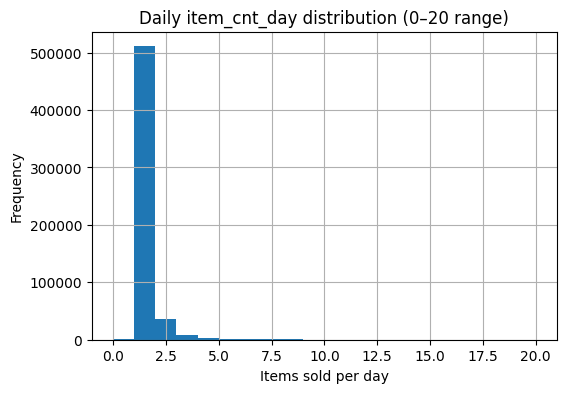

In [15]:
# === Basic EDA ===

# 1) Target distribution: daily item_cnt_day
plt.figure(figsize=(6,4))
sales["item_cnt_day"].clip(0,20).hist(bins=20, range=(0,20))
plt.title("Daily item_cnt_day distribution (0–20 range)")
plt.xlabel("Items sold per day")
plt.ylabel("Frequency")
plt.show()

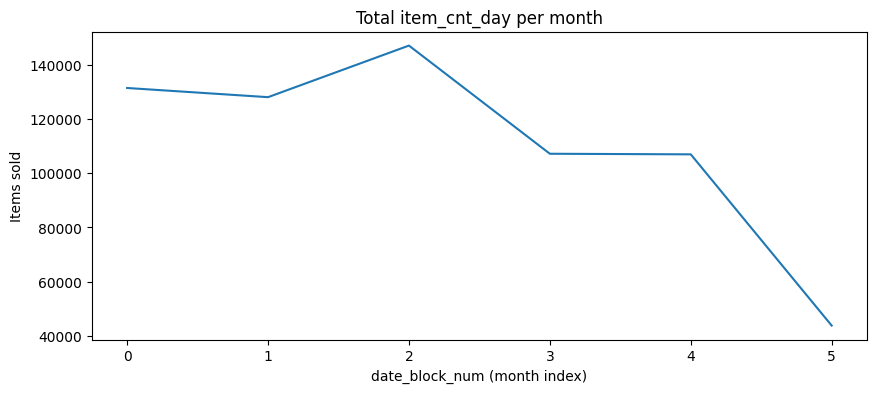

In [16]:
# 2) Monthly aggregated sales (sum)
monthly_sales = sales.groupby("date_block_num")["item_cnt_day"].sum()
plt.figure(figsize=(10,4))
monthly_sales.plot()
plt.title("Total item_cnt_day per month")
plt.xlabel("date_block_num (month index)")
plt.ylabel("Items sold")
plt.show()

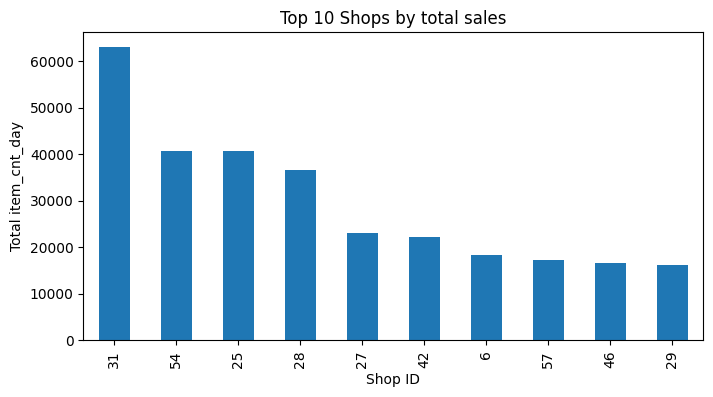

In [17]:
# 3) Top shops by sales
top_shops = sales.groupby("shop_id")["item_cnt_day"].sum().sort_values(ascending=False)[:10]
plt.figure(figsize=(8,4))
top_shops.plot(kind="bar")
plt.title("Top 10 Shops by total sales")
plt.xlabel("Shop ID")
plt.ylabel("Total item_cnt_day")
plt.show()

In [18]:
print("Min item_price:", sales["item_price"].min())
print("Max item_price:", sales["item_price"].max())
print("Min item_cnt_day:", sales["item_cnt_day"].min())
print("Max item_cnt_day:", sales["item_cnt_day"].max())

Min item_price: -1.0
Max item_price: 32990.0
Min item_cnt_day: -6.0
Max item_cnt_day: 88.0


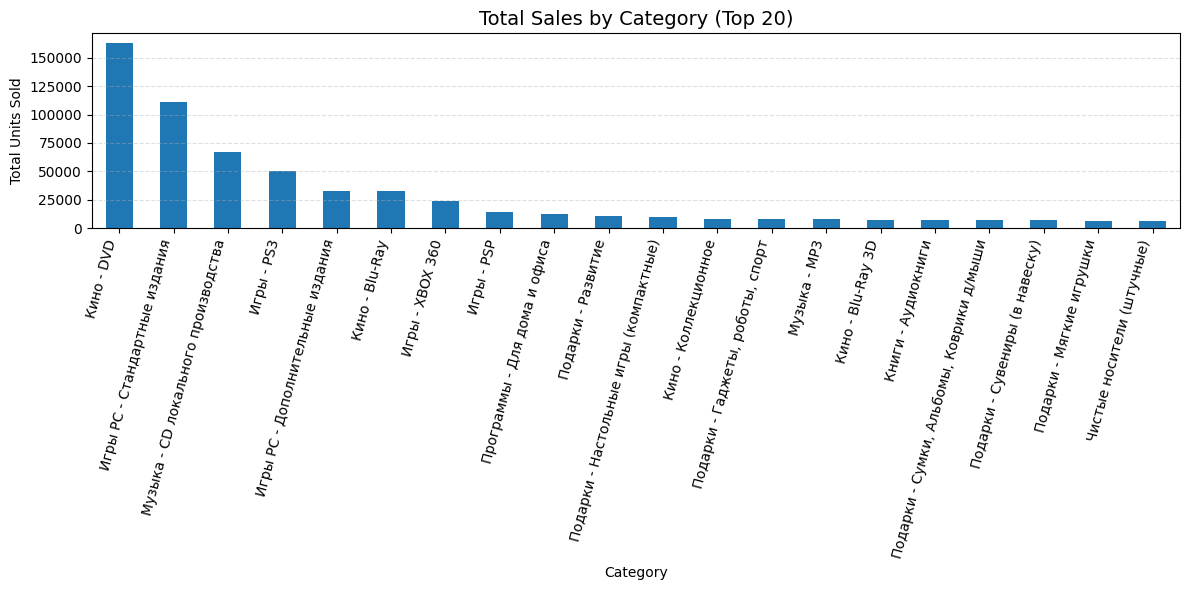

Top categories (share of total sales %):
item_category_name
Кино - DVD                             24.57
Игры PC - Стандартные издания          16.73
Музыка - CD локального производства    10.10
Игры - PS3                              7.61
Игры PC - Дополнительные издания        4.91
Кино - Blu-Ray                          4.90
Игры - XBOX 360                         3.64
Игры - PSP                              2.11
Программы - Для дома и офиса            1.84
Подарки - Развитие                      1.58
Name: item_cnt_day, dtype: float64


In [19]:
# === Total sales by category (Top 20) ===
# Join sales -> items -> item_categories to get readable category names
sales_items = (
    sales.merge(items[["item_id", "item_category_id"]], on="item_id", how="left")
         .merge(item_categories, on="item_category_id", how="left")
)

category_sales = (
    sales_items.groupby("item_category_name")["item_cnt_day"]
               .sum()
               .sort_values(ascending=False)
)

top_n = 20
top_cats = category_sales.head(top_n)

plt.figure(figsize=(12,6))
top_cats.plot(kind="bar")
plt.title(f"Total Sales by Category (Top {top_n})", fontsize=14)
plt.xlabel("Category")
plt.ylabel("Total Units Sold")
plt.xticks(rotation=75, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# (Optional) quick share to see dominance
share = (top_cats / category_sales.sum() * 100).round(2)
print("Top categories (share of total sales %):")
print(share.head(10))

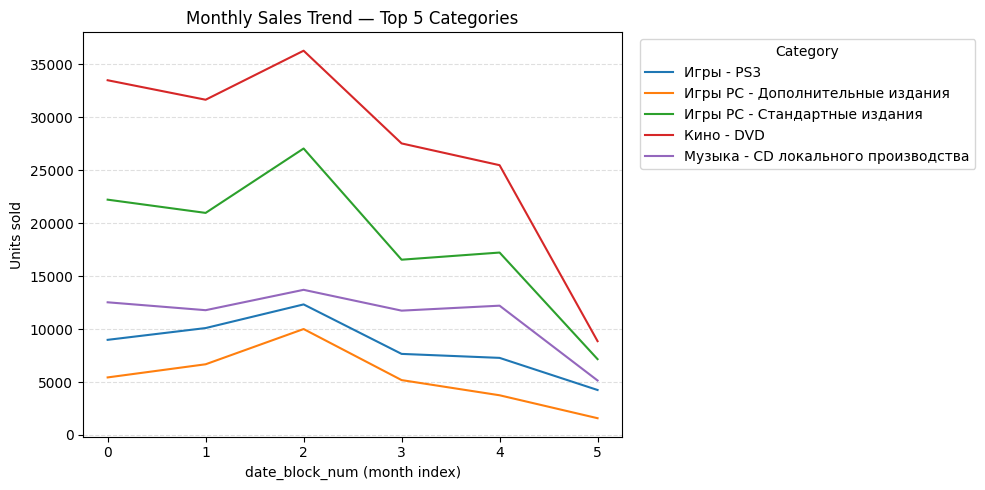

In [20]:
# === Monthly trend for Top 5 categories ===
top5_names = top_cats.index[:5]
monthly_cat = (
    sales_items[sales_items["item_category_name"].isin(top5_names)]
    .groupby(["date_block_num", "item_category_name"])["item_cnt_day"]
    .sum()
    .reset_index()
)

pivot_top5 = monthly_cat.pivot(index="date_block_num",
                               columns="item_category_name",
                               values="item_cnt_day").fillna(0)

plt.figure(figsize=(10,5))
pivot_top5.plot(ax=plt.gca())
plt.title("Monthly Sales Trend — Top 5 Categories")
plt.xlabel("date_block_num (month index)")
plt.ylabel("Units sold")
plt.legend(title="Category", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


In [21]:
# ------------------------------------------------
# Build monthly target (item_cnt_month) and clip to [0, 20]
# ------------------------------------------------
monthly = (
    sales
    .groupby(["date_block_num", "shop_id", "item_id"], as_index=False)["item_cnt_day"]
    .sum()
    .rename(columns={"item_cnt_day": "item_cnt_month"})
)
monthly["item_cnt_month"] = monthly["item_cnt_month"].clip(0, 20)

print(
    "monthly:", monthly.shape,
    "| date_block_num min/max:", monthly["date_block_num"].min(), monthly["date_block_num"].max()
)
monthly.head()

monthly: (313885, 4) | date_block_num min/max: 0 5


,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0


In [24]:
# === Train: lags (1,2,3) + month -> XGB (val = 5) ===
import numpy as np, xgboost as xgb
from sklearn.metrics import mean_squared_error

data = monthly.sort_values(["shop_id","item_id","date_block_num"]).copy()

# Lags + simple seasonality
for L in [1,2,3]:
    data[f"lag_{L}"] = data.groupby(["shop_id","item_id"])["item_cnt_month"].shift(L)
data["month"] = data["date_block_num"] % 12

# Nur Zeilen mit kompletten Lags behalten
data = data.dropna(subset=["lag_1","lag_2","lag_3"])

FEATURES = ["date_block_num","shop_id","item_id","month","lag_1","lag_2","lag_3"]

# Time-aware Split (val = month 5)
trn = data[data["date_block_num"] < 5]
val = data[data["date_block_num"] == 5]

dtr = xgb.DMatrix(trn[FEATURES], label=trn["item_cnt_month"])
dva = xgb.DMatrix(val[FEATURES], label=val["item_cnt_month"])

params = {"objective":"reg:squarederror","max_depth":8,"eta":0.3,
          "subsample":0.8,"colsample_bytree":0.8,"seed":42}
model = xgb.train(params, dtr, num_boost_round=300,
                  evals=[(dva,"val")], early_stopping_rounds=20, verbose_eval=50)

# Validation
pred_val = model.predict(dva).clip(0, 20)
y_val    = val["item_cnt_month"].to_numpy()
rmse = mean_squared_error(y_val, pred_val)
print("Validation RMSE:", np.sqrt(rmse))

[0]	val-rmse:2.37842
[36]	val-rmse:1.99319
Validation RMSE: 1.9936296943204663


In [25]:
# === Submission: predict month 34 using the same FEATURES ===
import pandas as pd, numpy as np, xgboost as xgb

# Monat 34 anhängen und Lags wieder berechnen
future = test[["shop_id","item_id"]].copy()
future["date_block_num"] = 34

combo = pd.concat([monthly, future], ignore_index=True, sort=False)
combo = combo.sort_values(["shop_id","item_id","date_block_num"])

for L in [1,2,3]:
    combo[f"lag_{L}"] = combo.groupby(["shop_id","item_id"])["item_cnt_month"].shift(L)
combo["month"] = combo["date_block_num"] % 12

test34 = combo[combo["date_block_num"] == 34]

# Vorhersage
dtest = xgb.DMatrix(test34[FEATURES])
pred34 = model.predict(dtest).clip(0, 20)

# Auf test.csv-ID-Reihenfolge mappen
test_sorted = test.sort_values("ID")
pred_df = test34[["shop_id","item_id"]].copy()
pred_df["pred"] = pred34
pred_series = pred_df.set_index(["shop_id","item_id"]).reindex(
    pd.MultiIndex.from_frame(test_sorted[["shop_id","item_id"]])
)["pred"].fillna(0).to_numpy()

sub = sample_submission.copy().sort_values("ID")
sub["item_cnt_month"] = pred_series
sub.to_csv("submission.csv", index=False)
print("✅ submission.csv saved:", sub.shape)

✅ submission.csv saved: (214200, 2)


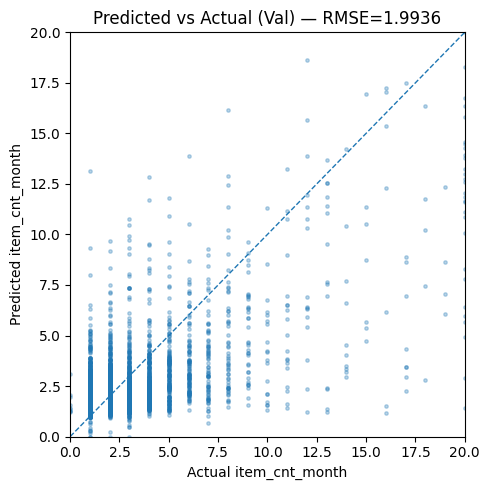

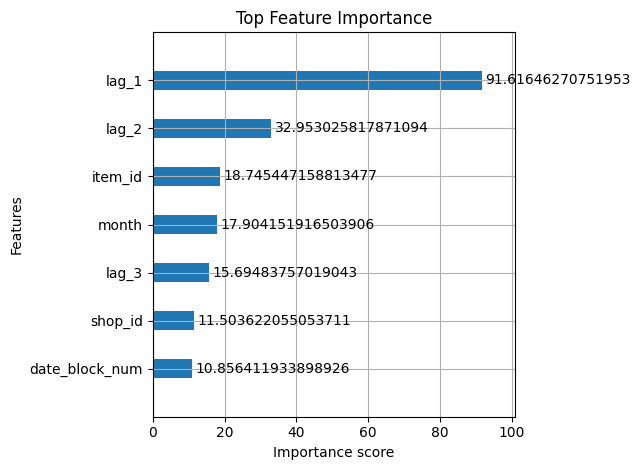

In [28]:
# 1) Predicted vs Actual (Scatter)
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
yv = np.asarray(y_val, float).ravel()
yp = np.asarray(pred_val, float).ravel()
yp = np.clip(yp, 0, 20)

idx = np.random.choice(len(yv), size=min(5000, len(yv)), replace=False)
plt.figure(figsize=(5,5))
plt.scatter(yv[idx], yp[idx], s=6, alpha=0.3)
lims = [0, max(20.0, yv.max(), yp.max())]
plt.plot(lims, lims, "--", lw=1); plt.xlim(lims); plt.ylim(lims)
rmse = mean_squared_error(yv, yp) # Removed squared=False
plt.title(f"Predicted vs Actual (Val) — RMSE={np.sqrt(rmse):.4f}") # Take square root to get RMSE
plt.xlabel("Actual item_cnt_month"); plt.ylabel("Predicted item_cnt_month")
plt.tight_layout(); plt.show()

# 2) Feature Importance
import xgboost as xgb
xgb.plot_importance(model, max_num_features=12, importance_type="gain", height=0.4)
plt.title("Top Feature Importance"); plt.tight_layout(); plt.show()